In [ ]:
import time
from datetime import datetime

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError as MSELoss
from tensorflow.keras.metrics import MeanAbsolutePercentageError as MAPEMetrics
from tensorflow.keras.metrics import MeanAbsoluteError as MAEMetrics
from tensorflow.keras.metrics import MeanSquaredError as MSEMetrics
from tensorflow.keras.metrics import R2Score

from tensorflow.keras.metrics import MeanAbsoluteError as 

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

2024-11-25 19:14:52.645781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732529692.662331 2188774 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732529692.667577 2188774 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 19:14:52.685228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('student_dataset/air_history.csv', header=None, names=['date', 'pollution'])

print(df.head(), '\n', df.tail())

                         date  pollution
0  2024-11-19 14:11:31.949450       7.00
1  2024-11-19 14:19:25.773944       0.07
2  2024-11-19 14:19:26.073293       0.05
3  2024-11-19 14:19:26.375484       0.09
4  2024-11-19 14:19:26.675016       0.09 
                             date  pollution
3653  2024-11-19 14:39:18.555263       0.24
3654  2024-11-19 14:39:18.853996       0.19
3655  2024-11-19 14:39:19.153123       0.19
3656  2024-11-19 14:39:19.451353       0.24
3657  2024-11-19 14:39:19.749941       0.34


In [3]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
print(df.head())

                            pollution
date                                 
2024-11-19 14:11:31.949450       7.00
2024-11-19 14:19:25.773944       0.07
2024-11-19 14:19:26.073293       0.05
2024-11-19 14:19:26.375484       0.09
2024-11-19 14:19:26.675016       0.09


<Axes: title={'center': 'Pollution Over Time'}, xlabel='date'>

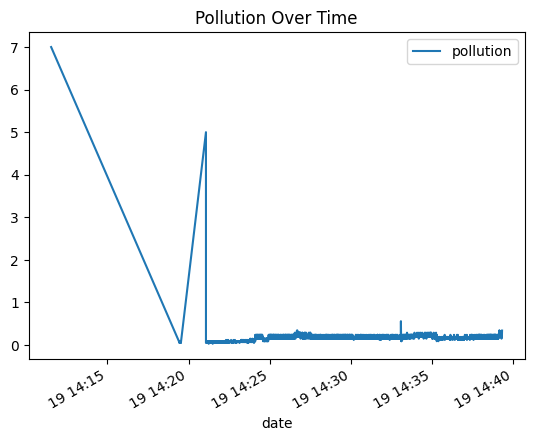

In [4]:
df.plot(y='pollution', kind='line', title='Pollution Over Time')

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3658 entries, 2024-11-19 14:11:31.949450 to 2024-11-19 14:39:19.749941
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  3658 non-null   float64
dtypes: float64(1)
memory usage: 57.2 KB
None


In [6]:
print(df.describe())

         pollution
count  3658.000000
mean      0.173026
std       0.148810
min       0.030000
25%       0.150000
50%       0.190000
75%       0.190000
max       7.000000


In [7]:
zScore = StandardScaler()
np_normed = zScore.fit_transform(df)

In [8]:
df_normed = pd.DataFrame(np_normed, columns = ['pollution'])

In [9]:
print(df_normed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3658 entries, 0 to 3657
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  3658 non-null   float64
dtypes: float64(1)
memory usage: 28.7 KB
None


In [ ]:
import torch

import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, dropout=0.):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        att = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32)))
        att = att.softmax(dim=-1)
        att = self.att_drop(att)
        x = (att @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, mlp_ratio=4.0, dropout=0., attn_dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = MultiHeadAttention(emb_size, num_heads, attn_dropout)
        self.drop_path = nn.Identity()
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, int(emb_size * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(emb_size * mlp_ratio), emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=1000, emb_size=768, depth=12, num_heads=8, mlp_ratio=4.0, dropout=0., attn_dropout=0.):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))
        self.pos_drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            TransformerEncoderLayer(emb_size, num_heads, mlp_ratio, dropout, attn_dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(emb_size)
        self.head = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

# Example usage
model = VisionTransformer()
img = torch.randn(1, 3, 224, 224)
preds = model(img)
print(preds.shape)  # torch.Size([1, 1000])

In [ ]:
import torch

import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (name + "conv1", nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False)),
                    (name + "norm1", nn.BatchNorm2d(features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "conv2", nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False)),
                    (name + "norm2", nn.BatchNorm2d(features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

# Example usage
model = UNet(in_channels=3, out_channels=1, init_features=32)
print(model)

In [10]:
print(df_normed.describe())

          pollution
count  3.658000e+03
mean   3.185593e-16
std    1.000137e+00
min   -9.612655e-01
25%   -1.547571e-01
50%    1.140790e-01
75%    1.140790e-01
max    4.588343e+01


<Axes: title={'center': 'Pollution Over Time'}>

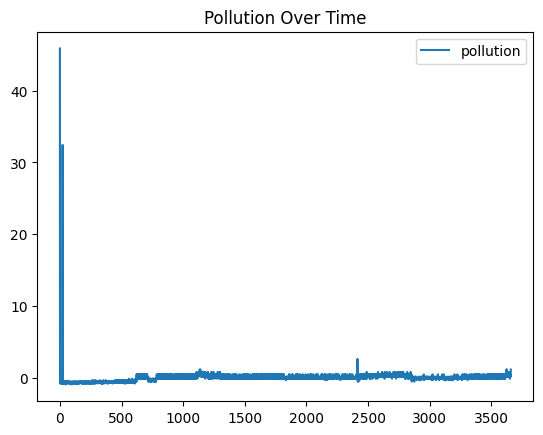

In [11]:
df_normed.plot(y='pollution', kind='line', title='Pollution Over Time')

In [12]:
val_length = 0.2
lr = 1e-3
labels_length = 30
seq_length = 15
data_features = 1
batch_size = 128
epochs = 1000

In [13]:
train_size = int((len(df_normed) - labels_length) * (1 - val_length))
val_size = int((len(df_normed) - labels_length) - train_size)
print('\nData length: ', len(df_normed), '\nTrain data size: ', train_size, '\nVal data size: ', val_size)

df_train = pd.DataFrame(df_normed.iloc[0:train_size, :])
df_valid = pd.DataFrame(df_normed.iloc[train_size:train_size+val_size, :])
df_test = pd.DataFrame(df_normed.iloc[train_size+val_size:, :])

print('\nData length: ', len(df_train), '\nData head: ', df_train.head(), '\nData tail: ', df_train.tail())
print('\nData length: ', len(df_valid), '\nData head: ', df_valid.head(), '\nData tail: ', df_valid.tail())


Data length:  3658 
Train data size:  2902 
Val data size:  726

Data length:  2902 
Data head:     pollution
0  45.883426
1  -0.692429
2  -0.826847
3  -0.558011
4  -0.558011 
Data tail:        pollution
2897  -0.154757
2898  -0.154757
2899  -0.154757
2900  -0.154757
2901  -0.154757

Data length:  726 
Data head:        pollution
2902  -0.154757
2903  -0.154757
2904  -0.154757
2905  -0.154757
2906  -0.154757 
Data tail:        pollution
3623   1.122214
3624   0.450124
3625   1.122214
3626   0.450124
3627   0.114079


In [14]:
def create_dataset (X, y, look_back = 1):
    Xs, ys = [], []
 
    for i in range(0,len(X)-look_back):
        v = X[i:i+look_back]
        w = y[i+look_back]
        Xs.append(v)
        ys.append(w)
 
    return np.array(Xs), np.array(ys)

In [15]:
np_train = df_train.to_numpy()
np_valid = df_valid.to_numpy()
np_test = df_test.to_numpy()

X_train, y_train = create_dataset(np_train,np_train, seq_length)
X_valid, y_valid = create_dataset(np_valid,np_valid, seq_length)
X_test, y_test = create_dataset(np_test,np_test, seq_length)

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(2887, 15, 1)
(2887, 1)
(711, 15, 1)
(711, 1)


In [17]:
def create_model(units):
    model = Sequential()
    model.add(Input(shape=(seq_length, data_features)))
    model.add(SimpleRNN(units = units*2, return_sequences=True))
    model.add(SimpleRNN(units = units*5, return_sequences=True))
    model.add(SimpleRNN(units = 1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse',
                  metrics=[MAEMetrics(), MSEMetrics(), MAPEMetrics(), tf.nn.log_poisson_loss, R2Score])
    return model

model_build = create_model(seq_length)

I0000 00:00:1732529694.231948 2188774 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21924 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6


In [18]:
model_build.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 15, 30)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 15, 75)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 1)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,987 (35.11 KB)

 Trainable params: 8,987 (35.11 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
checkpoint_path = 'model_store/11a_best_model.weights.h5'

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop_callback = EarlyStopping(monitor='loss', min_delta=0.000001, patience=20)
hist_callback = tf.keras.callbacks.History()
reduceLR_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.005, patience=10, verbose=1, min_delta=0.000001)

In [20]:
def fit_model(model):
    history = model.fit(X_train, y_train, epochs=epochs,  
                        validation_data=(X_valid, y_valid),
                        batch_size=batch_size, shuffle=True,
                        # callbacks=[cp_callback, hist_callback, earlystop_callback, reduceLR_callback])
                        callbacks=[cp_callback, hist_callback, reduceLR_callback])
    return history

In [21]:
start_time = time.time()
st_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
st_time2 = datetime.now().strftime('%Y%m%d %H%M%S')
print('Start time: ', datetime.now())

train_history = fit_model(model_build)

print('Start time: ', st_time, '\nFinished time: ', datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print('Overall training time: ', (time.time()-start_time)/3600, ' hours')

Start time:  2024-11-25 19:14:55.173606
Epoch 1/1000


I0000 00:00:1732529696.700176 2188978 service.cc:148] XLA service 0xb5d7120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732529696.700204 2188978 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-25 19:14:56.749531: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732529696.928466 2188978 cuda_dnn.cc:529] Loaded cuDNN version 90300


22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - log_poisson_loss: 1.0628 - loss: 0.7938 - mean_absolute_error: 0.3389 - mean_absolute_percentage_error: 177.9039 - mean_squared_error: 0.7938 - r2_score: -0.1647

I0000 00:00:1732529697.603040 2188978 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - log_poisson_loss: 1.0605 - loss: 0.7810 - mean_absolute_error: 0.3361 - mean_absolute_percentage_error: 176.3192 - mean_squared_error: 0.7810 - r2_score: -0.1557
Epoch 1: val_loss improved from inf to 0.07091, saving model to model_store/11a_best_model.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - log_poisson_loss: 1.0584 - loss: 0.7692 - mean_absolute_error: 0.3336 - mean_absolute_percentage_error: 174.8666 - mean_squared_error: 0.7692 - r2_score: -0.1475 - val_log_poisson_loss: 1.0607 - val_loss: 0.0709 - val_mean_absolute_error: 0.2131 - val_mean_absolute_percentage_error: 131.6978 - val_mean_squared_error: 0.0709 - val_r2_score: -0.4330 - learning_rate: 0.0010
Epoch 2/1000
13/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - log_poisson_loss: 0.9906 - loss: 0.7916 - mean_absolute_error: 0.2280 - mean_absolute_percentage_error: 104.4720 - mean_squared_error: 0.7916 - r2_score: 0.1902 
Epoch 2: val_loss improved from 0.07091 to 0.05047, saving mo

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


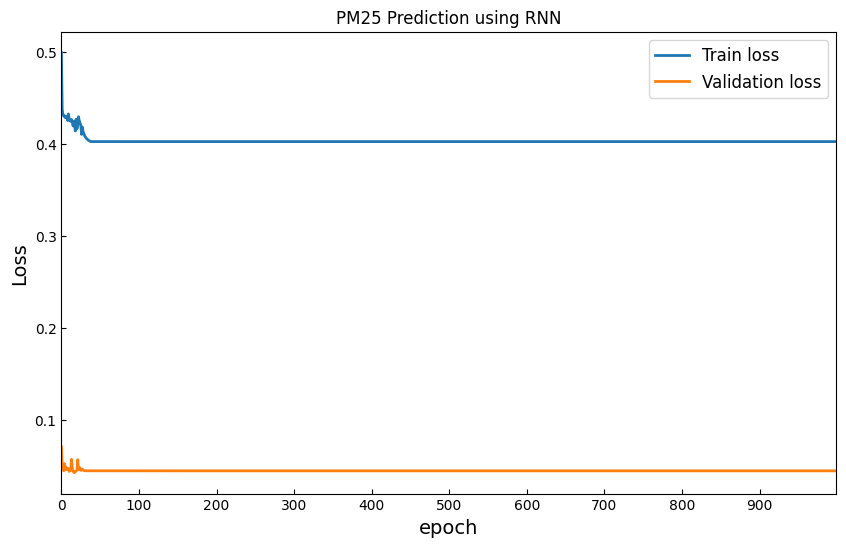

In [22]:
def plot_loss (history):
    fig, ax= plt.subplots(figsize = (10, 6))
    ax.set_xlim(0, len(history.history['loss'])-1)
#     ax.set_ylim(0, 1)
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    ax.xaxis.set_major_locator(MultipleLocator(0.1*len(history.history['loss'])))
#     ax.yaxis.set_major_locator(MultipleLocator(.2))
    
    plt.plot(history.history['loss'],linewidth=2)
    plt.plot(history.history['val_loss'],linewidth=2)
    csfont = {'fontname':'Times New Roman'}
    plt.title('PM25 Prediction using RNN')
    plt.ylabel('Loss',fontsize=14,**csfont)
    plt.xlabel('epoch',fontsize=14,**csfont)
    plt.legend(['Train loss', 'Validation loss'], loc='upper right',fontsize=12)

plot_loss(train_history)

In [23]:
model_build.load_weights(checkpoint_path)

In [24]:
prediction_result = model_build.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


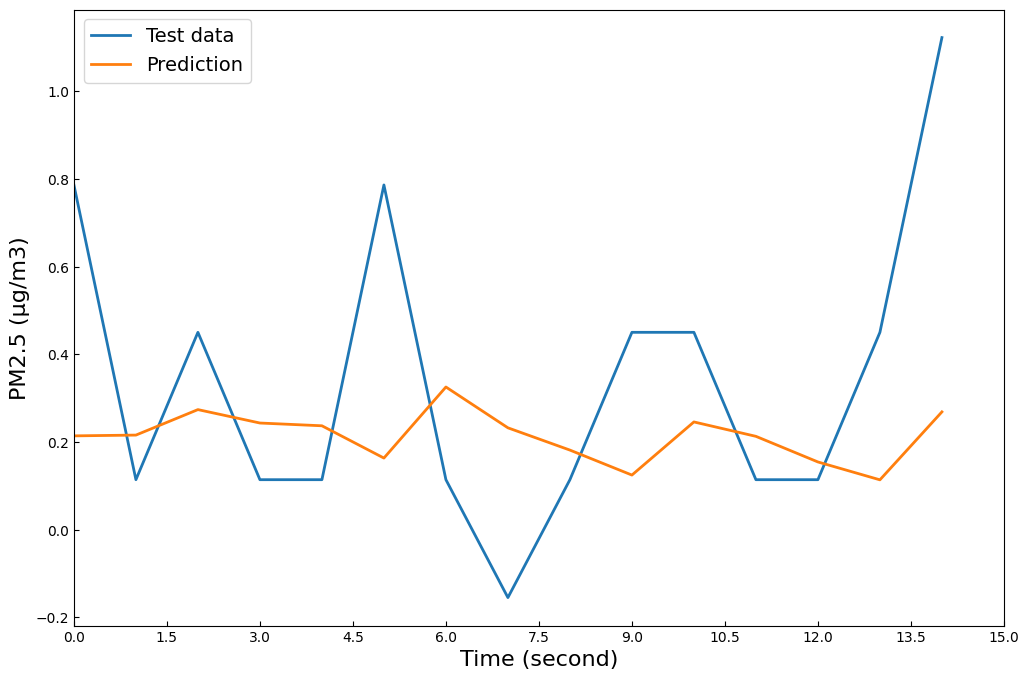

In [25]:
def plot_future(prediction, y_test):
    fig, ax= plt.subplots(figsize = (12, 8))
    ax.set_xlim(0, y_test.shape[0])
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    ax.xaxis.set_major_locator(MultipleLocator(0.1*y_test.shape[0]))
    csfont = {'fontname':'Times New Roman'}
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test),  label='Test data',linewidth=2)
    plt.plot(np.arange(range_future),np.array(prediction),label='Prediction',linewidth=2)
    plt.legend(loc='upper left',fontsize=14)
    plt.xlabel('Time (second)',fontsize=16,**csfont)
    plt.ylabel('PM2.5 (µg/m3)',fontsize=16,**csfont)
    
plot_future(prediction_result, y_test)